# Deep Learning
# DL03 Red neuronales con PyTorch

Las redes de aprendizaje profundo tienden a ser masivas con docenas o cientos de capas, de ahí proviene el término "profundo". Puede construir una de estas redes profundas utilizando solo matrices de peso como lo hicimos anteriormente, pero en general es muy engorroso y difícil de implementar. PyTorch tiene un buen módulo `nn` que proporciona una buena manera de construir eficientemente grandes redes neuronales.

In [ ]:
# Importemos las librerias necesarias.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

#import helper

import matplotlib.pyplot as plt

### El dataset MNIST

Ahora vamos a construir una red más grande que pueda resolver un problema difícil. Identificaremos el texto en una imagen. Aquí usaremos el conjunto de datos __MNIST__ que consta de dígitos escritos a mano en escala de grises. Cada imagen es de 28x28 píxeles, puede ver una muestra a continuación:

![MNIST](https://drive.google.com/uc?export=view&id=1YzIWb0FariLWdmpoy7dC0OzObAlZibBZ)


Nuestro objetivo es construir una red neuronal que pueda tomar una de estas imágenes y predecir el dígito en la imagen. Primero, necesitamos obtener nuestro conjunto de datos. Esto se proporciona a través del paquete `torchvision`. El siguiente código descargará el conjunto de datos MNIST, luego creará conjuntos de datos de *entrenamiento* y prueba para nosotros. No se preocupe demasiado por los detalles aquí, aprenderá más sobre esto más adelante.



### Cargando el dataset.

Vamos a cargar el dataset utilizando funcionalidades de Pytorch. Particularmente con `DataLoader` podemos definir el `batch_size` y `shuffle`.

In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
from torchvision import datasets, transforms

# Aqui estamos normalizando la data.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Aqui estamos bajando los datos
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
# Contiene grupos de 64.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

`Compose` crea una serie de transformaciones para preparar el conjunto de datos. `Torchvision` lee conjuntos de datos en `PILImage` (formato de imágenes de Python). `ToTensor` convierte la imagen `PIL` del rango $[0, 255]$ a un `FloatTensor` de forma $(C x H x W)$ con rango $[0.0, 1.0]$. Luego volvemos a normalizar la entrada a $[-1, 1]$ según la siguiente fórmula con $\mu = \sigma = 0.5$.

In [ ]:
# Obtenemos un objeto que es iterable con iter()
type(trainloader)

torch.utils.data.dataloader.DataLoader

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

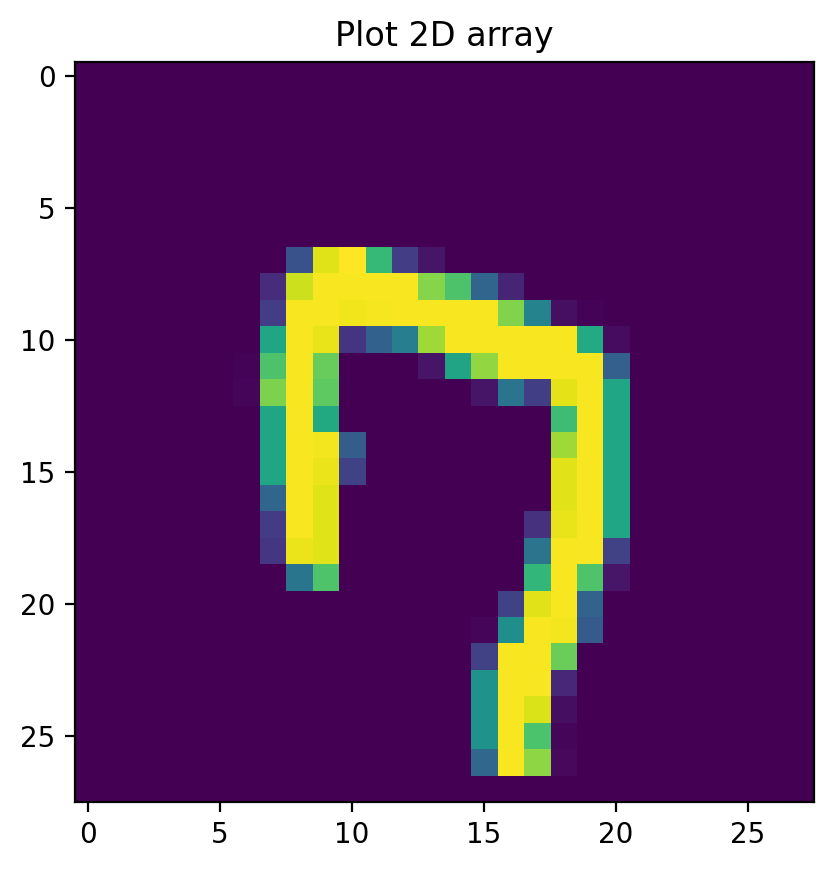

In [ ]:
# DECONSTRUCCION a la antigua. Luego mostraremos otra forma
# Imprimimos un lote de 64 imágenes
for image, label in trainloader:
    print(image)
    print(label)
    # Nos guardamos el primer tensor
    i = image[0]
    l = label[0]
    break
print(i.shape) # Atención que el tensor tiene 3 dimensiones
print(i.view(28,28)) # Lo reformateamos a dos dimensiones para poder visualizarlo
print('Label = ', l.item())
#plt.imshow(i.view(28,28)) # o de la siguiente forma
plt.imshow(i[0, :, :])
plt.title("Plot 2D array")
plt.show()

In [ ]:
i[0,:,:].shape

torch.Size([28, 28])

Hasta aqui, tenemos los datos de entrenamiento cargados en `trainloader` y lo podemos iterar con` iter (trainloader) `. Más tarde usaremos la iteracion con el objetivo de  recorrer el conjunto de datos para entrenamiento, por ejemplo:


```python
for image, label in trainloader:
    ## Ejecute acciones con imagenes y labels.
```

Debemos observar que el `trainloader` tienen un tamaño de lote de 64 y `shuffle = True`. El tamaño del lote es el número de imágenes que obtenemos en una iteración del cargador de datos y pasamos a través de nuestra red, a menudo llamado *lote*. El  `shuffle = True` le dice que baraje el conjunto de datos cada vez que comenzamos a pasar por el cargador de datos nuevamente. Aquí solo tomaremos el primer lote para que podamos ver los datos. Podemos ver a continuación que `imágenes` es solo un tensor con tamaño `(64, 1, 28, 28)`. Entonces, 64 imágenes por lote, 1 canal de color y 28x28 imágenes.

### Iteremos nuestro trainloader

Aquí utilizaremos `iter` para ir iterando, observe la dimensión de los tensores obtenidos.

In [ ]:
# Vamos a mirar una imagen concreta.
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Así es como se ve una de las imágenes.

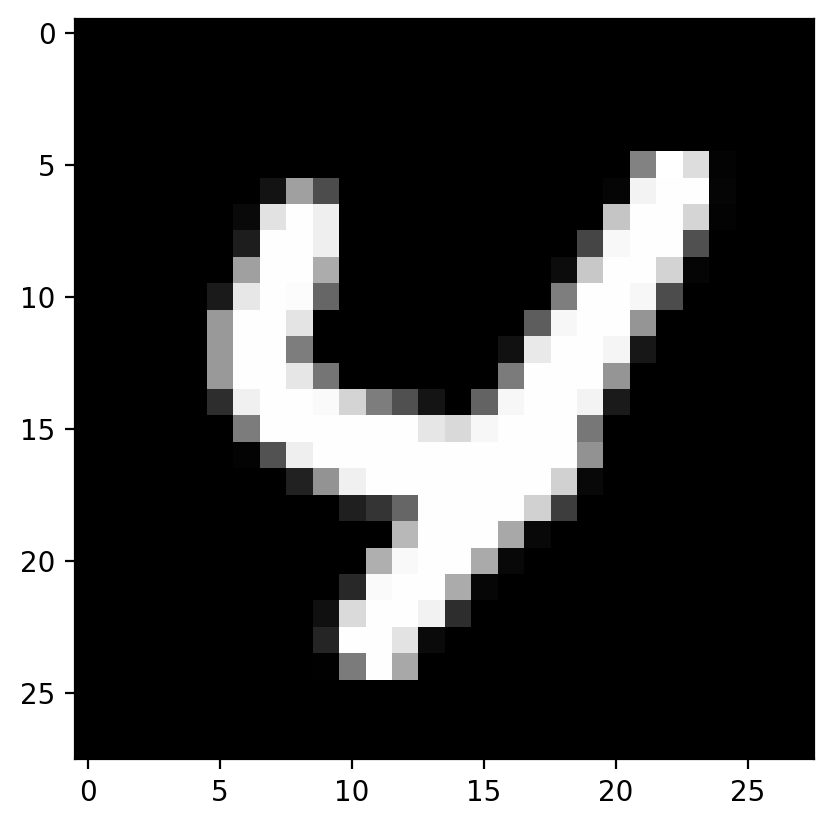

In [ ]:
# Elimina las dimesniones de valor 1. Es decir deja 28, 28.
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Construyendo una red  fully-connected.

Primero, intentemos construir una red simple para este conjunto de datos usando matrices de peso y multiplicaciones de matrices. Luego, veremos cómo hacerlo utilizando el módulo `nn` de PyTorch que proporciona un método mucho más conveniente y poderoso para definir arquitecturas de red.

Las redes que has visto hasta ahora se llaman redes *fully-connected* o *densas*. Cada unidad en una capa está conectada a cada unidad en la siguiente capa. En redes completamente conectadas, la entrada a cada capa debe ser un vector unidimensional (que puede apilarse en un tensor 2D como un lote de ejemplos múltiples). Sin embargo, nuestras imágenes son tensores 2D de 28x28, por lo que debemos convertirlos en vectores 1D. Pensando en los tamaños, necesitamos convertir el lote de imágenes con forma `(64, 1, 28, 28)` para que tenga una forma de `(64, 784)`, 784 es 28 veces 28. Esto generalmente se llama *Al aplastar(flattening)*, aplanamos las imágenes 2D en vectores 1D.

Anteriormente construyó una red con una unidad de salida. Aquí necesitamos 10 unidades de salida, una para cada dígito. Queremos que nuestra red prediga el dígito que se muestra en una imagen, por lo que lo que haremos será calcular las probabilidades de que la imagen sea de un solo dígito o clase. Esto termina siendo una distribución de probabilidad discreta sobre las clases (dígitos) que nos dice la clase más probable para la imagen. Eso significa que necesitamos 10 unidades de salida para las 10 clases (dígitos). A continuación, veremos cómo convertir la salida de la red en una distribución de probabilidad.

> **Ejemplo:** Acoplemos el lote de imágenes `images`. Luego construya una red multicapa con 784 unidades de entrada, 256 unidades ocultas y 10 unidades de salida utilizando tensores aleatorios para los pesos y sesgos. Por ahora, use una activación sigmoidea para la capa oculta. Deje la capa de salida sin una activación, agregaremos una que nos da una distribución de probabilidad a continuación.

### Contruyendo la red a mano.

Esta red tiene de entrada 28x28 y 256 nodos en la primera capa.

1. Se define un primer tensor $w_1$ de 784x256 y un tensor  bias $b_1$ de 256.

2. Posteriromente se define otro tensor $w_2$ de 256x10 ademas de un bias $b_2$ de dimension 10.

In [ ]:
## Solution
def activation(x):
    return 1/(1+torch.exp(-x))

# la aplastamos para obtener un vector de 784.
inputs = images.view(images.shape[0], -1)

# Iniciamos los pesos y los bias. Estamos considerando una red con una capa interna de 256.
w1 = torch.randn(784, 256)
b1 = torch.randn(256)
# Estamos considerando una capa de salida de 10. Uno por cada digito.
w2 = torch.randn(256, 10)
b2 = torch.randn(10)

# Aplicamos la activacion en la capa interna.
h = activation(torch.mm(inputs, w1) + b1)

# Luego multiplicacion en la capa externa.
# ATENCION. No aplicamos la función de activación, sino que aplicaremos otra función denominada 'softmax'
out = torch.mm(h, w2) + b2

In [ ]:
out

tensor([[ 1.1318e+00, -1.1127e+01,  1.9556e+01, -1.3265e+00,  2.6646e+00,
         -3.1472e+01, -1.0357e+01, -2.0403e+00, -1.7221e+01, -2.0753e+01],
        [ 7.8820e+00, -1.1395e+01,  1.6386e+01, -1.4591e+00,  6.1152e+00,
         -3.2426e+01, -1.0857e+01, -4.9774e+00, -2.0171e+01, -1.9764e+01],
        [ 1.4993e+01, -3.1603e+00,  1.1729e+01,  1.3443e+01,  5.4201e+00,
         -1.5088e+01,  7.4886e-01, -8.4454e-02, -1.2386e+01, -2.6483e+01],
        [ 1.0031e+01, -8.7092e+00,  9.7748e+00, -6.7546e+00,  2.0137e+00,
         -2.9901e+01, -6.6727e+00, -5.4816e+00, -1.2492e+01, -1.5512e+01],
        [ 8.1491e+00, -1.2184e+00,  2.5795e+01, -2.2601e+01,  1.9545e+00,
         -2.8475e+01, -2.0877e+00,  5.4814e+00, -6.7113e+00, -2.4100e+01],
        [ 1.1814e+00, -1.0219e+01,  1.9879e+01, -1.7404e+01,  2.3500e+00,
         -3.2934e+01, -8.9614e+00, -3.0416e+00,  2.0941e+00, -2.1959e+01],
        [ 5.7127e+00,  2.7642e+00,  5.8226e+00, -7.1647e+00, -5.5460e-01,
         -3.3138e+01,  3.4033e+0

Ahora tenemos 10 salidas para nuestra red. Queremos pasar una imagen a nuestra red y obtener una distribución de probabilidad sobre las clases que nos indique las clases probables a las que pertenece la imagen. Algo que se parece a esto:

![Distribución](https://drive.google.com/uc?export=view&id=1HK8rfRF8BOQFxhn35f156DuL9tMnq1Zw)


Aquí vemos que la probabilidad para cada clase es aproximadamente la misma. Esto representa una red no entrenada, aún no ha visto ningún dato, por lo que solo devuelve una distribución uniforme con iguales probabilidades para cada clase.

Para calcular esta distribución de probabilidad, a menudo utilizamos la función [**softmax**](https://en.wikipedia.org/wiki/Softmax_function) o __función exponencial normalizada__. Matemáticamente se ve asi:

$$
\sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

Lo que esto hace es aplastar cada entrada $x_i$ entre 0 y 1 y normaliza los valores para darle una distribución de probabilidad adecuada donde las probabilidades suman uno.

> **Ejemplo:** Implemente una función `softmax` que realice el cálculo de softmax y devuelva distribuciones de probabilidad para cada ejemplo en el lote. Tenga en cuenta que deberá prestar atención a las formas al hacer esto. Si tiene un tensor `a` con forma` (64, 10) `y un tensor` b` con forma `(64,)`, hacer `a / b` le dará un error porque PyTorch intentará hacer el división a través de las columnas (llamada broadcasting) pero obtendrá un desajuste de tamaño. La forma de pensar sobre esto es para cada uno de los 64 ejemplos, solo desea dividir por un valor, la suma en el denominador. Por lo tanto, necesita 'b' para tener una forma de `(64, 1)`. De esta manera, PyTorch dividirá los 10 valores en cada fila de `a` por el valor uno en cada fila de` b`. Presta atención también a cómo tomas la suma. Tendrá que definir la palabra clave `dim` en` torch.sum`. Establecer `dim = 0` toma la suma a través de las filas, mientras que` dim = 1` toma la suma a través de las columnas.

#### Construyamos nuestra función softmax.

In [ ]:
"""
Esto es un ejemplo para entender la transformacion realizda por torch.exp y torch.sum.
"""
print(out.shape)
test = torch.sum(torch.exp(out), dim=1).view(-1, 1)
print(test.shape)

torch.Size([64, 10])
torch.Size([64, 1])


In [ ]:
## Solucion
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)
print(probabilities.shape)
# Suman 1?.
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [ ]:
probabilities[0]

tensor([9.9651e-09, 4.7256e-14, 1.0000e+00, 8.5279e-10, 4.6151e-08, 6.9023e-23,
        1.0209e-13, 4.1769e-10, 1.0667e-16, 3.1190e-18])

Con esto construimos una red neuronal que tiene dos capas ocultas, sobre la primera capa aplica una función sigmoide y sobre la segunda aplica una función softmax.

### Vamos a construir la red con PyTorch

PyTorch proporciona un módulo `nn` que hace que la construcción de redes sea mucho más simple. Aquí mostraremos cómo construir la misma red anterior con 784 entradas, 256 unidades ocultas, 10 unidades de salida y una salida softmax.

La función __Linear__, aplica una transformacion lineal de los datos de entrada de la siguiente forma:

$$y = xA^T + b$$


```python
class Network(nn.Module):
```
Aquí estamos heredando de `nn.Module`. Combinado con `super().__init__()` esto crea una clase que hereda la arquitectura y proporciona  métodos y atributos útiles de la clase base. Es obligatorio heredar de `nn.Module` cuando está creando una clase para su red. El nombre de la clase en sí puede ser cualquier cosa.

```python
self.hidden = nn.Linear(784, 256)
```

Esta línea crea un módulo para una transformación lineal, $ x \mathbf{W} + b $, con 784 entradas y 256 salidas y lo asigna a `self.hidden`. El módulo crea automáticamente los tensores de peso y bias que usaremos en el método `forward`. Puede acceder a los tensores de peso y bias una vez que la red (`net`) se crea con `net.hidden.weight` y `net.hidden.bias`.


```python
self.output = nn.Linear(256, 10)
```

Del mismo modo, esto crea otra transformación lineal con 256 entradas y 10 salidas.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```
Aquí definimos las  operaciones para la activación sigmoidea y la salida softmax. La configuración de `dim = 1` en `nn.Softmax (dim = 1)` calcula softmax en las columnas.


```python
def forward(self, x):
```
Las redes PyTorch creadas con `nn.Module` deben tener un método ` forward` definido. Toma un tensor `x` y lo pasa a través de las operaciones que definió en el método `__init__`.


```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```
Aquí el tensor de entrada `x` se pasa a través de cada operación y se reasigna a` x`. Podemos ver que el tensor de entrada atraviesa la capa oculta, luego una función sigmoidea, luego la capa de salida y finalmente la función softmax. No importa cómo nombre las variables aquí, siempre que las entradas y salidas de las operaciones coincidan con la arquitectura de red que desea construir. El orden en el que define las cosas en el método `__init__` no importa, pero deberá secuenciar las operaciones correctamente en el método` forward`.

Ahora podemos crear un objeto `Network`.



```
model = Network()
model
```



### <font color='green'>**Actividad 1**</font>

Construya una clase Network que herede de nn.Module.
```
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defina una capa escondida fully connected considerando una entrada de 784  y 256 nodos.
        self.hidden = nn.Linear(784, 256)
        # Defina una capa de salida fully connected considerando una entrada de 256  y 10 nodos.  
        # Defina una función de activación sigmoidea y una de softmax.
        
    def forward(self, x):
        # Pasemos el tensor de entrada a través de cada una de las operaciones definidas anteriormente.
        return x
```



In [ ]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Capa escondida: entrada de 784 y salida de 256 nodos
        self.hidden = nn.Linear(784, 256)
        # Capa de salida: entrada de 256 y salida de 10 nodos
        self.output = nn.Linear(256, 10)
        # Activaciones
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)  # softmax en dimensión de clases

    def forward(self, x):
        # Paso 1: capa escondida con activación sigmoide
        x = self.sigmoid(self.hidden(x))
        # Paso 2: capa de salida con activación softmax
        x = self.softmax(self.output(x))
        return x

<font color='green'>**Fin Actividad 1**</font>

Se puede definir la red de manera más concisa y clara utilizando el módulo `torch.nn.functional`. Esta es la forma más común de ver las redes definidas, ya que muchas operaciones son funciones simples basadas en elementos. Normalmente importamos este módulo como `F`,` import torch.nn.functional como F`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Entradas a la transformación lineal de capa oculta
        self.hidden = nn.Linear(784, 256)
        # Capa de salida, 10 unidades, una por cada dígito
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        # Capa oculta con activación sigmoidea
        x = F.sigmoid(self.hidden(x))
        # Capa de salida con activación softmax
        x = F.softmax(self.output(x), dim=1)
        return x


### Funciones de activación.


Hasta ahora solo hemos estado mirando la activación de softmax y la sigmoidea, pero en general cualquier función se puede usar como función de activación. El único requisito es que para que una red se aproxime a una función no lineal, las funciones de activación deben ser no lineales. Aquí hay algunos ejemplos más de funciones de activación comunes: __Tanh__ (tangente hiperbólica) y __ReLU__ (unidad lineal rectificada).



![Funciones de activacion](https://drive.google.com/uc?export=view&id=1WoyUS1AHsiIO99lRVwNF0ZpcNlkLQhh0)


En la práctica, la función ReLU se usa casi exclusivamente como la función de activación para capas ocultas. Es muy usada para clasificación de imágenes.

### <font color='green'>**Actividad 2**</font>
Construya una red neuronal con 3 capas ocultas.

![NN 3 capas ocultas](https://drive.google.com/uc?export=view&id=1AsDCgA5GvP7XQMDAVvN7fwYxaku8Z1XR)




>**Ejercicio:** Cree una red con 784 unidades de entrada, una capa oculta con 128 unidades y una activación ReLU, luego una capa oculta con 64 unidades y una activación ReLU, y finalmente una capa de salida con una activación softmax como se muestra arriba. Puede utilizar una activación ReLU con el módulo `nn.ReLU` o la función `F.relu`.

Es una buena práctica nombrar sus capas por su tipo de red, por ejemplo `fc` para representar una capa completamente conectada. A medida que codifica su solución, use `fc1`, `fc2` y `fc3` como sus nombres de capa.

In [ ]:
# Codigo Aqui
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Capa completamente conectada de entrada a primera capa oculta (784 → 128)
        self.fc1 = nn.Linear(784, 128)
        # Segunda capa oculta (128 → 64)
        self.fc2 = nn.Linear(128, 64)
        # Capa de salida (64 → 10)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # ReLU para las dos primeras capas ocultas
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Softmax en la capa de salida (dim=1 para que aplique por fila)
        x = F.softmax(self.fc3(x), dim=1)
        return x

<font color='green'>**Fin Actividad 2**</font>

#### Iniciando pesos y bias.

Los pesos y bias se inicializan automáticamente, pero tambien es posible personalizar cómo se inicializan. Los pesos y los bias son tensores unidos a la capa que los definió, por ejemplo, puede obtenerlos con `model.fc1.weight`.

In [ ]:
model = Network()
print('Pesos')
print(model.fc1.weight)
print('Bias')
print(model.fc1.bias)

Pesos
Parameter containing:
tensor([[ 2.2253e-02,  1.1824e-02,  3.4092e-02,  ..., -2.3439e-02,
          3.4390e-02, -1.9469e-02],
        [ 1.0357e-02, -2.5629e-02, -5.9687e-03,  ..., -9.7971e-03,
         -1.3740e-02, -9.2864e-05],
        [-2.3386e-02,  9.9042e-03, -2.8998e-02,  ...,  1.4905e-02,
         -1.4578e-02, -1.7252e-02],
        ...,
        [-1.0429e-02,  2.0029e-02, -8.0832e-03,  ..., -1.5513e-02,
          1.9201e-02,  2.9695e-02],
        [ 1.1984e-02,  2.6338e-02, -3.4334e-02,  ..., -1.3141e-02,
         -1.1836e-02,  2.6863e-02],
        [-1.6578e-02, -2.6564e-02,  6.1687e-03,  ...,  1.2513e-02,
         -1.5334e-03,  1.6314e-02]], requires_grad=True)
Bias
Parameter containing:
tensor([ 0.0190, -0.0021, -0.0238,  0.0260,  0.0108,  0.0344, -0.0152, -0.0012,
         0.0321,  0.0320,  0.0250,  0.0009,  0.0067, -0.0175,  0.0155, -0.0295,
         0.0228,  0.0144,  0.0014, -0.0146, -0.0179,  0.0016,  0.0217, -0.0152,
        -0.0066, -0.0255, -0.0128,  0.0356,  0.0003, 

Para la inicialización personalizada, queremos modificar estos tensores en su lugar. Necesitamos recuperar los tensores reales con `model.fc1.weight.data`. Una vez que tenemos los tensores, podemos llenarlos con ceros (para bias) o valores normales aleatorios.

In [ ]:
# Configure los bias a cero.
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# muestra de normal aleatorio con dev estándar = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-1.7569e-02,  4.5346e-03,  3.1066e-04,  ..., -1.4086e-04,
          1.5540e-02, -1.1664e-03],
        [-4.7703e-03,  8.2512e-03,  9.5986e-03,  ..., -1.0706e-02,
         -2.0506e-04, -5.3434e-03],
        [ 1.0241e-02, -2.4230e-03,  4.0498e-03,  ...,  2.5259e-02,
          1.0009e-03,  7.5246e-03],
        ...,
        [ 6.2411e-03, -3.8264e-03, -6.8760e-03,  ...,  1.9430e-02,
          2.3664e-02,  9.3644e-03],
        [ 1.2422e-02,  6.8093e-03,  6.8854e-03,  ..., -7.5919e-03,
          5.6705e-05,  9.8876e-04],
        [ 1.6735e-02,  1.0448e-03,  1.5908e-02,  ..., -5.9136e-03,
         -4.9600e-03,  1.2431e-03]])

### Forward pass

Ahora que tenemos una red construida, veamos qué sucede cuando pasamos una imagen. A continuación una función que nos permite visualizar la imagen.

In [ ]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    # Define el tamaño de la figura y numero de gráficos.
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    # Se reformatea al original. 28*28 recuerde que lo dejamos como un vector de 784.
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    # Maquillaje
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
      # Las distintas clases.
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Probabilidad de la Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

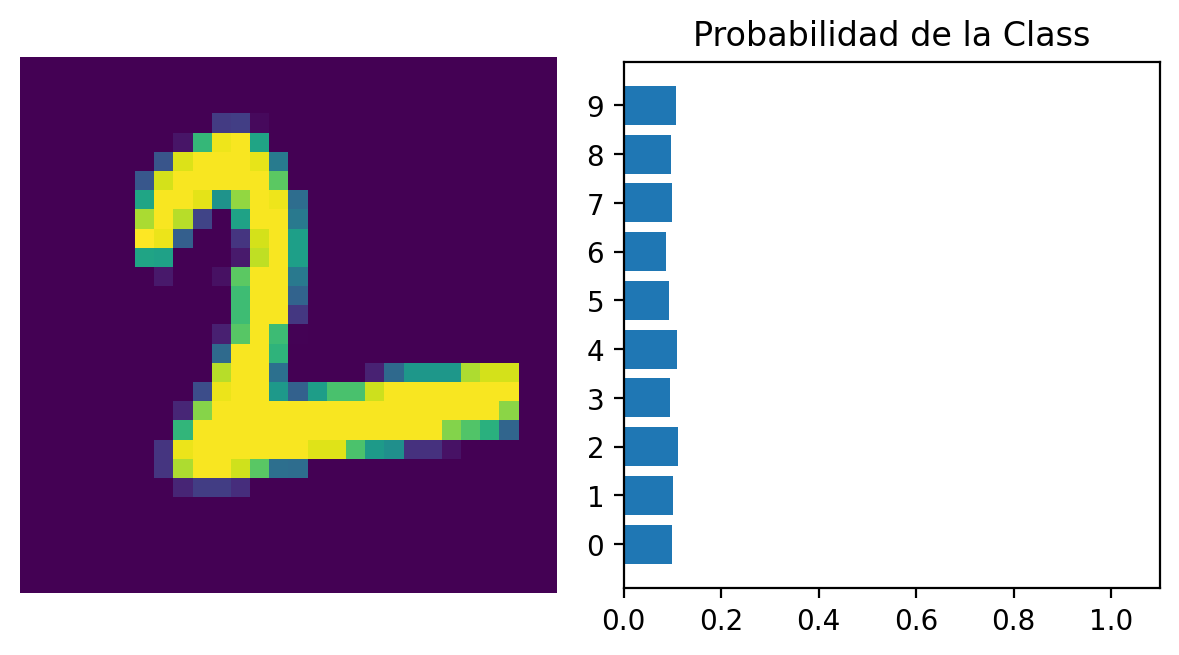

In [ ]:
# Tomemos un paquete de imagenes.
dataiter = iter(trainloader)
images, labels = next(dataiter)


# Transformemos la imagen en vector. Le sacamos la dimensiones 28x28
images.resize_(64, 1, 784)
# o images.resize_(images.shape[0], 1, 784) automaticamente obtener el tamaño del batch.

# Pasar forward a través de la red
img_idx = 9
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

En este momento lo que hemos hecho es pasarle una imagen a la red y ver el resultado. no la hemos entrenado aún. Si se fijan, las probabilidades que entrega __softmax__ son todas muy parecidas.

In [ ]:
print(ps)

tensor([[0.1001, 0.1007, 0.1119, 0.0958, 0.1101, 0.0928, 0.0862, 0.0985, 0.0967,
         0.1071]], grad_fn=<SoftmaxBackward0>)


Como puede ver arriba, nuestra red básicamente no tiene idea de qué es este dígito. Es porque todavía no lo hemos entrenado, ¡todos los pesos son aleatorios!

<img src="https://drive.google.com/uc?export=view&id=1DNuGbS1i-9it4Nyr3ZMncQz9cRhs2eJr" width="100" align="left" title="Runa-perth">
<br clear="left">

## <font color='green'>**Material anexo.**</font>



### Usando  `nn.Sequential`

`nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Usando esto para construir la red equivalente:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


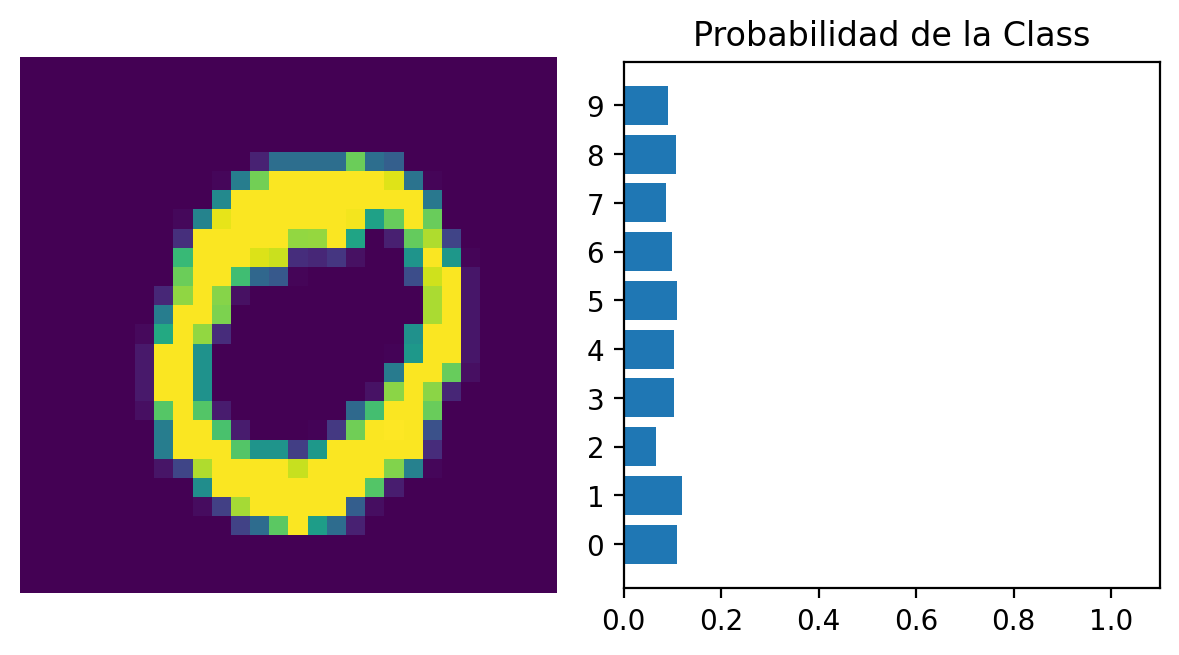

In [ ]:
# Los Hyperparametros de la red.
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Vamos a construir una red feed/forward.
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward a través de la red.
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

__Nota:__ Las operaciones están disponibles pasando el índice apropiado. Por ejemplo, si desea obtener la primera operación lineal y ver los pesos, usaría `model[0]`.

In [ ]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0293,  0.0192, -0.0010,  ...,  0.0062,  0.0014,  0.0009],
        [-0.0019,  0.0334,  0.0291,  ...,  0.0133,  0.0324,  0.0157],
        [-0.0247, -0.0342,  0.0237,  ..., -0.0012,  0.0352,  0.0351],
        ...,
        [ 0.0082,  0.0330, -0.0225,  ..., -0.0190,  0.0237,  0.0093],
        [ 0.0032, -0.0175, -0.0343,  ...,  0.0058, -0.0111,  0.0067],
        [-0.0006,  0.0280, -0.0108,  ..., -0.0157, -0.0333,  0.0018]],
       requires_grad=True)

También puede pasar un `OrderedDict` para nombrar las capas y operaciones individuales, en lugar de usar enteros incrementales. Tenga en cuenta que las claves del diccionario deben ser únicas, por lo que cada operación debe tener un nombre diferente.

In [ ]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model


Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Ahora puede acceder a las capas ya sea por entero o por el nombre

In [ ]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


<img src="https://drive.google.com/uc?export=view&id=1Igtn9UXg6NGeRWsqh4hefQUjV0hmzlBv" width="100" align="left" title="Runa-perth">
<br clear="left">

## Ejercicio Avanzado:

**Clasificación de Ropa**

En este ejercicio, trabajarán con el conjunto de datos FashionMNIST, que consiste en imágenes de prendas de vestir en 10 categorías: camisetas, pantalones, suéteres, vestidos, abrigos, sandalias, camisas, zapatillas, bolsas y botas. Cada imagen tiene una resolución de 28x28 píxeles y está etiquetada con una de las 10 categorías.

Objetivo: Construir una red neuronal para clasificar las imágenes de prendas de vestir en las 10 categorías.

Pasos:

Importar las bibliotecas necesarias (torch, torchvision, etc.).

Cargar el conjunto de datos FashionMNIST utilizando torchvision.datasets.FashionMNIST. Dividir los datos en conjuntos de entrenamiento y prueba.

Visualizar algunas imágenes del conjunto de datos.

Definir la arquitectura de la red neuronal. Usar una red neuronal de tres capas, similar a la que se proporcionó en el ejemplo inicial. Utilizar funciones de activación ReLU para las capas ocultas.

Definir la función de pérdida. Usar la función de pérdida de entropía cruzada nn.CrossEntropyLoss().

Realizar un paso forward con un lote de imágenes del conjunto de entrenamiento.

Calcular la función de pérdida con las predicciones obtenidas y las etiquetas reales.

Imprimir el valor de la función de pérdida.

Instrucciones adicionales:

No realice un paso de backpropagation ni optimización en este ejercicio.
Puede usar la función view_classify() proporcionada en el ejemplo inicial para visualizar las predicciones de la red.
Este ejercicio tiene como objetivo que los alumnos practiquen la construcción de la arquitectura de la red, el paso forward y el cálculo de la función de pérdida en una red neuronal utilizando PyTorch. En ejercicios posteriores, podrán abordar la backpropagation y optimización para mejorar el rendimiento de la red en la clasificación de prendas de vestir.



100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.0MB/s]


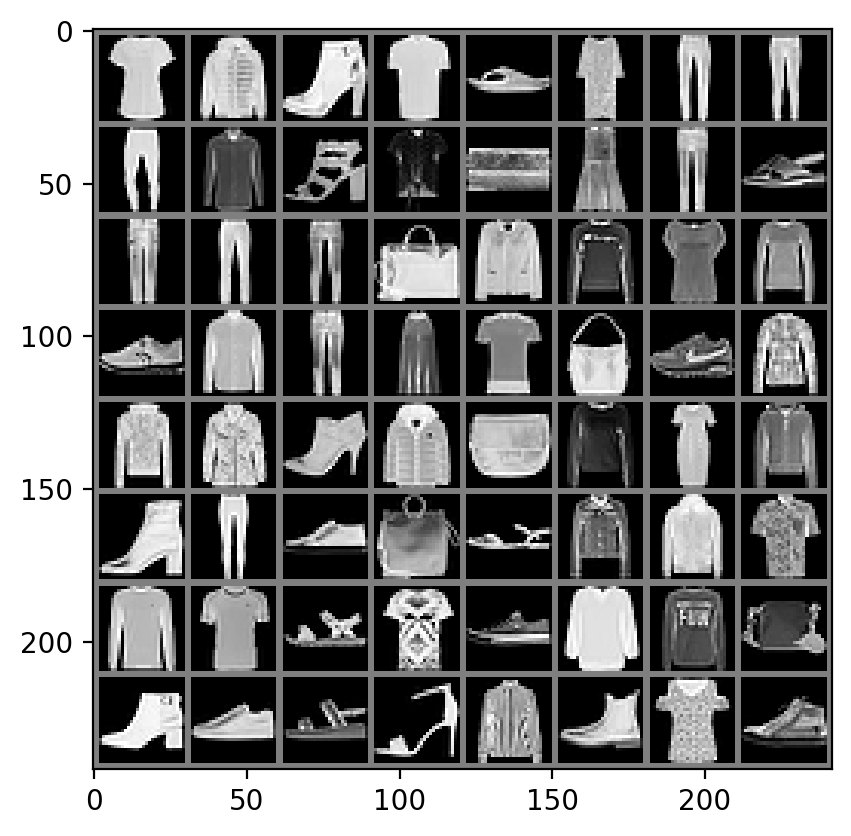

Loss: 2.2861101627349854


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# Transformación para convertir las imágenes en tensores y normalizarlas
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar el conjunto de datos FashionMNIST
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualizar algunas imágenes del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Definir la arquitectura de la red neuronal
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instanciar la red neuronal
model = Network()

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Realizar un paso forward con un lote de imágenes
images, labels = next(iter(trainloader))
outputs = model(images)

# Calcular la función de pérdida
loss = criterion(outputs, labels)

# Imprimir el valor de la función de pérdida
print(f"Loss: {loss.item()}")


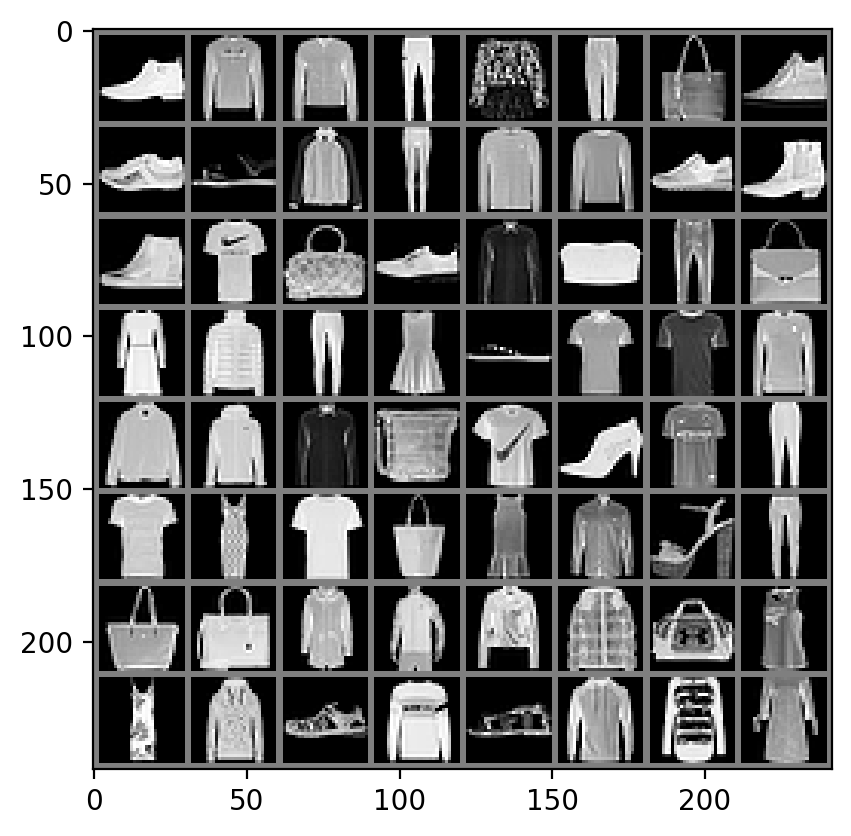

Loss: 2.2970492839813232


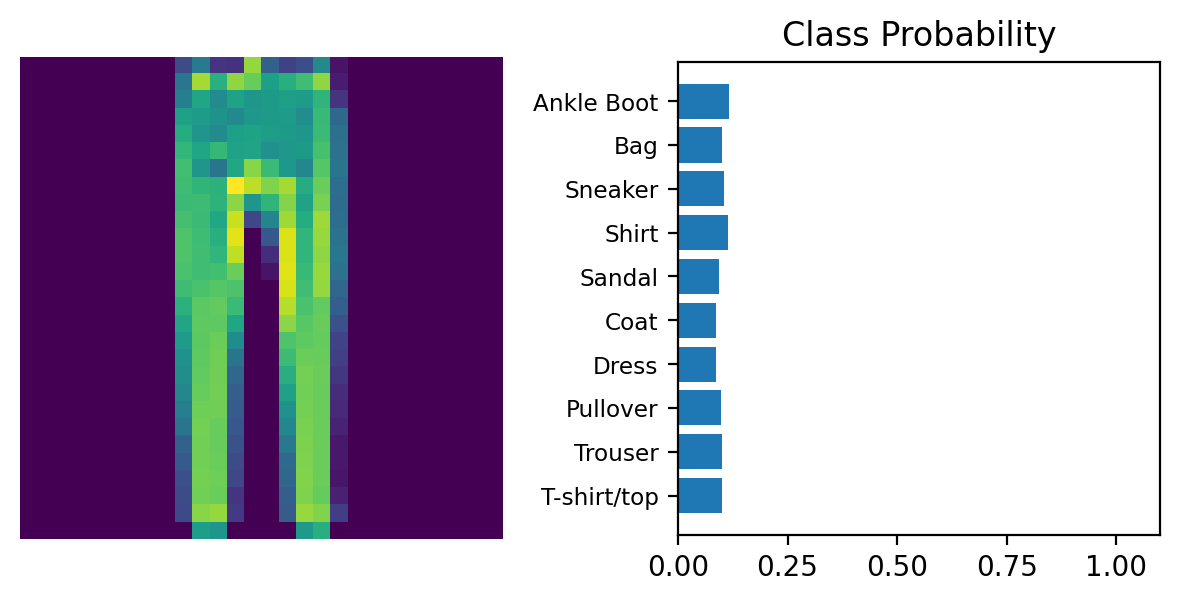

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# Transformación para convertir las imágenes en tensores y normalizarlas
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Cargar el conjunto de datos FashionMNIST
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualizar algunas imágenes del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def view_classify(img, ps, version="Fashion"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                         'Trouser',
                         'Pullover',
                         'Dress',
                         'Coat',
                         'Sandal',
                         'Shirt',
                         'Sneaker',
                         'Bag',
                         'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# Definir la arquitectura de la red neuronal
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instanciar la red neuronal
model = Network()

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Realizar un paso forward con un lote de imágenes
images, labels = next(iter(trainloader))
outputs = model(images)

# Calcular la función de pérdida
loss = criterion(outputs, labels)

# Imprimir el valor de la función de pérdida
print(f"Loss: {loss.item()}")

# Visualizar las predicciones
img_idx = 9
ps = F.softmax(outputs, dim=1)
view_classify(images[img_idx].view(1, 28, 28), ps[img_idx])
